In [2]:
print("hello")

hello


In [3]:
!pip install tensorflow-datasets --quiet

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
# 3. Hyperparameters
image_size = 512
nz = 100  # Latent vector size
batch_size = 16  # reduce to avoid Colab memory issues
num_epochs = 100
lr = 0.0002
beta1 = 0.5

In [7]:
# 4. Data Preparation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

print("Loading dataset...")
ds = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
processed = []

for sample in tfds.as_numpy(ds):
    image = sample['image']
    try:
        tensor_img = transform(image)
        processed.append(tensor_img)
    except:
        continue

images = torch.stack(processed)
dataset = TensorDataset(images)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("Dataset loaded with", len(images), "images.")

Loading dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.72FQEF_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.72FQEF_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.72FQEF_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Dataset loaded with 1020 images.


In [8]:
# 5. Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024), nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16), nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [9]:
# 6. Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [10]:
# 7. Initialize models and optimizers
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Fixed noise for generating consistent outputs
fixed_noise = torch.randn(1, nz, 1, 1, device=device)


Epoch [1/100] | D Loss: 0.3247 | G Loss: 8.8034
Epoch [2/100] | D Loss: 0.7685 | G Loss: 13.0647
Epoch [3/100] | D Loss: 0.0712 | G Loss: 7.0755
Epoch [4/100] | D Loss: 0.0320 | G Loss: 5.8657
Epoch [5/100] | D Loss: 0.0080 | G Loss: 6.2331
Epoch [6/100] | D Loss: 0.0068 | G Loss: 6.6068
Epoch [7/100] | D Loss: 0.0021 | G Loss: 7.2914
Epoch [8/100] | D Loss: 0.0021 | G Loss: 7.3782
Epoch [9/100] | D Loss: 0.6700 | G Loss: 17.9210
Epoch [10/100] | D Loss: 0.0135 | G Loss: 6.2453


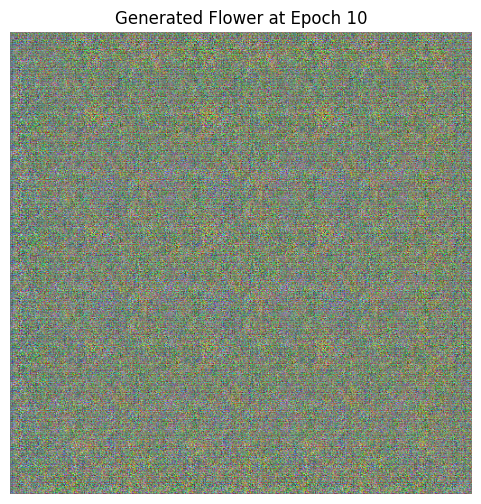

Epoch [11/100] | D Loss: 0.0074 | G Loss: 6.7789
Epoch [12/100] | D Loss: 0.0123 | G Loss: 6.7298
Epoch [13/100] | D Loss: 0.1164 | G Loss: 5.4986
Epoch [14/100] | D Loss: 0.0193 | G Loss: 5.5753
Epoch [15/100] | D Loss: 0.0518 | G Loss: 5.4543
Epoch [16/100] | D Loss: 0.0057 | G Loss: 6.0098
Epoch [17/100] | D Loss: 0.0123 | G Loss: 6.2494
Epoch [18/100] | D Loss: 0.0645 | G Loss: 5.1434
Epoch [19/100] | D Loss: 0.0426 | G Loss: 4.7863
Epoch [20/100] | D Loss: 0.0070 | G Loss: 6.7664


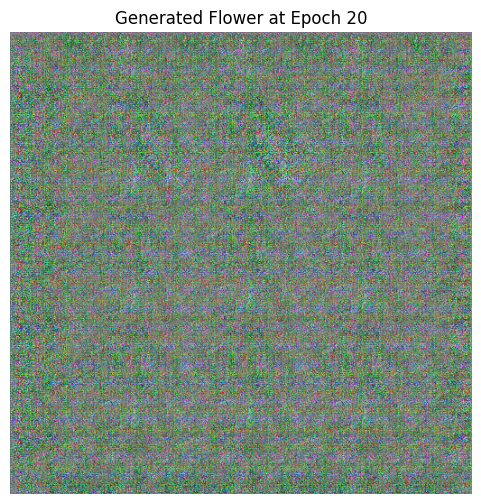

Epoch [21/100] | D Loss: 0.0023 | G Loss: 6.5959
Epoch [22/100] | D Loss: 0.0023 | G Loss: 6.7017
Epoch [23/100] | D Loss: 0.0646 | G Loss: 4.9444
Epoch [24/100] | D Loss: 0.0274 | G Loss: 5.3344
Epoch [25/100] | D Loss: 0.0171 | G Loss: 5.6204
Epoch [26/100] | D Loss: 0.0091 | G Loss: 6.2082
Epoch [27/100] | D Loss: 0.0028 | G Loss: 6.7423
Epoch [28/100] | D Loss: 0.0030 | G Loss: 7.1864
Epoch [29/100] | D Loss: 1.5039 | G Loss: 2.2625
Epoch [30/100] | D Loss: 2.7522 | G Loss: 7.3149


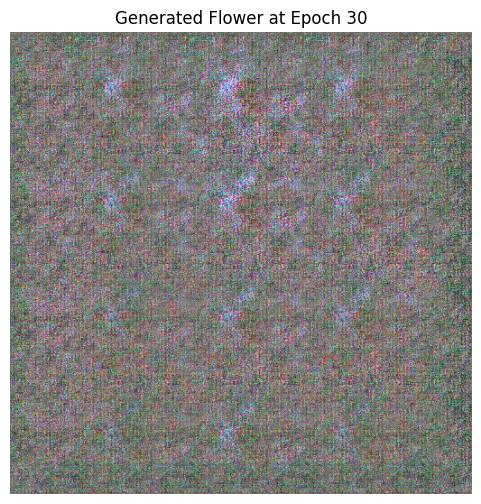

Epoch [31/100] | D Loss: 0.0190 | G Loss: 5.1553
Epoch [32/100] | D Loss: 0.0061 | G Loss: 5.5114
Epoch [33/100] | D Loss: 0.0369 | G Loss: 4.3272
Epoch [34/100] | D Loss: 0.0099 | G Loss: 5.7192
Epoch [35/100] | D Loss: 0.0072 | G Loss: 7.3269
Epoch [36/100] | D Loss: 1.8655 | G Loss: 7.5871
Epoch [37/100] | D Loss: 0.4299 | G Loss: 2.9809
Epoch [38/100] | D Loss: 1.1266 | G Loss: 6.7556
Epoch [39/100] | D Loss: 9.9229 | G Loss: 9.0318
Epoch [40/100] | D Loss: 2.9556 | G Loss: 8.0615


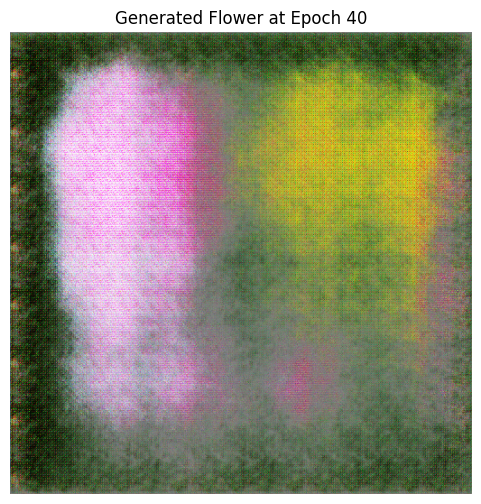

Epoch [41/100] | D Loss: 1.5479 | G Loss: 0.4879
Epoch [42/100] | D Loss: 0.0878 | G Loss: 4.7915
Epoch [43/100] | D Loss: 0.6872 | G Loss: 3.8429
Epoch [44/100] | D Loss: 0.9927 | G Loss: 3.8702
Epoch [45/100] | D Loss: 0.3317 | G Loss: 4.4155
Epoch [46/100] | D Loss: 0.1832 | G Loss: 3.9242
Epoch [47/100] | D Loss: 1.7081 | G Loss: 5.9913
Epoch [48/100] | D Loss: 0.7879 | G Loss: 1.3714
Epoch [49/100] | D Loss: 0.8551 | G Loss: 2.1183
Epoch [50/100] | D Loss: 1.0291 | G Loss: 3.4605


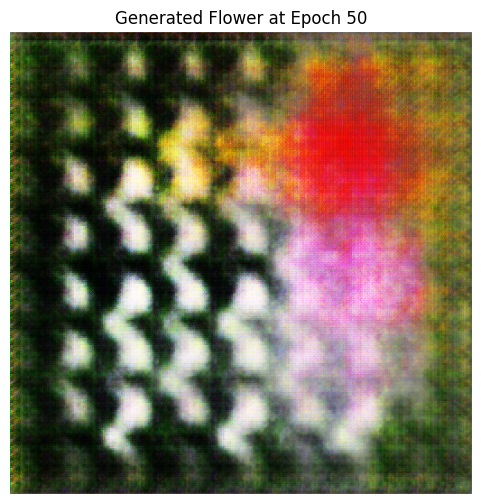

Epoch [51/100] | D Loss: 1.4533 | G Loss: 0.6988
Epoch [52/100] | D Loss: 0.4088 | G Loss: 4.7171
Epoch [53/100] | D Loss: 2.4156 | G Loss: 0.7799
Epoch [54/100] | D Loss: 0.5795 | G Loss: 3.8225
Epoch [55/100] | D Loss: 0.8643 | G Loss: 1.6678
Epoch [56/100] | D Loss: 0.6393 | G Loss: 2.3329
Epoch [57/100] | D Loss: 0.6021 | G Loss: 3.5637
Epoch [58/100] | D Loss: 0.5388 | G Loss: 4.4449
Epoch [59/100] | D Loss: 0.8619 | G Loss: 1.7685
Epoch [60/100] | D Loss: 1.2605 | G Loss: 0.2469


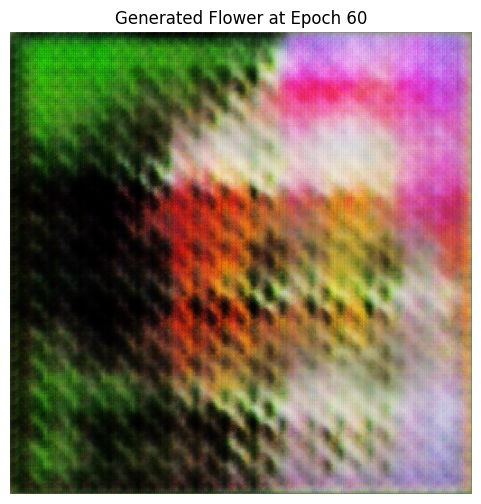

Epoch [61/100] | D Loss: 1.3946 | G Loss: 3.8772
Epoch [62/100] | D Loss: 0.5661 | G Loss: 4.2600
Epoch [63/100] | D Loss: 0.9570 | G Loss: 5.6876
Epoch [64/100] | D Loss: 1.3684 | G Loss: 1.4881
Epoch [65/100] | D Loss: 0.8392 | G Loss: 4.2601
Epoch [66/100] | D Loss: 0.7541 | G Loss: 3.5733
Epoch [67/100] | D Loss: 0.4317 | G Loss: 5.0748
Epoch [68/100] | D Loss: 0.5154 | G Loss: 2.6739
Epoch [69/100] | D Loss: 0.1214 | G Loss: 4.2105
Epoch [70/100] | D Loss: 1.0513 | G Loss: 0.8863


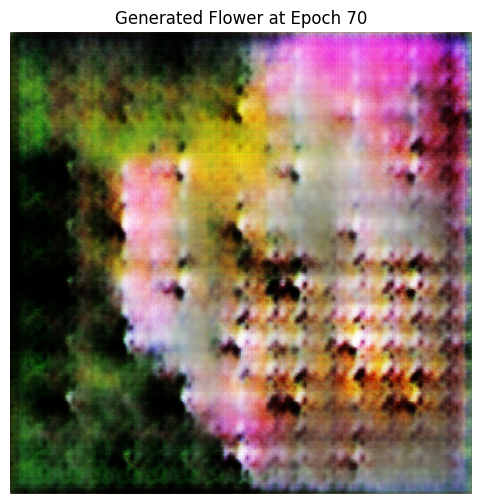

Epoch [71/100] | D Loss: 2.0808 | G Loss: 6.2678
Epoch [72/100] | D Loss: 1.6988 | G Loss: 6.1088
Epoch [73/100] | D Loss: 3.7178 | G Loss: 3.6243
Epoch [74/100] | D Loss: 0.5754 | G Loss: 3.1621
Epoch [75/100] | D Loss: 0.8750 | G Loss: 2.6782
Epoch [76/100] | D Loss: 1.2691 | G Loss: 2.5950
Epoch [77/100] | D Loss: 0.9473 | G Loss: 4.3769
Epoch [78/100] | D Loss: 0.5937 | G Loss: 4.6512
Epoch [79/100] | D Loss: 0.9977 | G Loss: 1.8606
Epoch [80/100] | D Loss: 1.2689 | G Loss: 1.2857


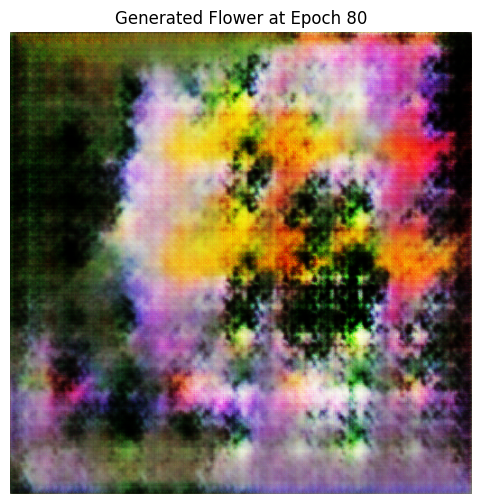

Epoch [81/100] | D Loss: 0.7276 | G Loss: 1.9188
Epoch [82/100] | D Loss: 0.9497 | G Loss: 5.1087
Epoch [83/100] | D Loss: 0.9292 | G Loss: 2.3998
Epoch [84/100] | D Loss: 0.8147 | G Loss: 2.1359
Epoch [85/100] | D Loss: 0.9865 | G Loss: 1.5934
Epoch [86/100] | D Loss: 1.0922 | G Loss: 4.5845
Epoch [87/100] | D Loss: 0.4166 | G Loss: 3.7628
Epoch [88/100] | D Loss: 0.5084 | G Loss: 1.7900
Epoch [89/100] | D Loss: 0.7423 | G Loss: 2.9286
Epoch [90/100] | D Loss: 1.2587 | G Loss: 6.3988


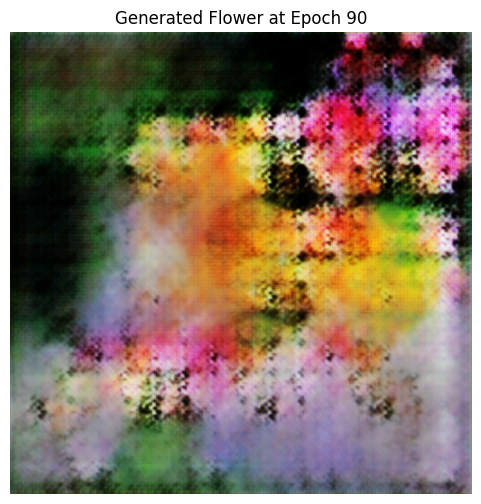

Epoch [91/100] | D Loss: 0.8019 | G Loss: 4.0694
Epoch [92/100] | D Loss: 0.8441 | G Loss: 3.3301
Epoch [93/100] | D Loss: 0.7535 | G Loss: 2.3422
Epoch [94/100] | D Loss: 1.3516 | G Loss: 3.3538
Epoch [95/100] | D Loss: 0.4605 | G Loss: 3.4698
Epoch [96/100] | D Loss: 1.1655 | G Loss: 2.2047
Epoch [97/100] | D Loss: 1.4280 | G Loss: 1.6950
Epoch [98/100] | D Loss: 0.9906 | G Loss: 3.9245
Epoch [99/100] | D Loss: 0.8781 | G Loss: 4.3628
Epoch [100/100] | D Loss: 0.5279 | G Loss: 2.7444


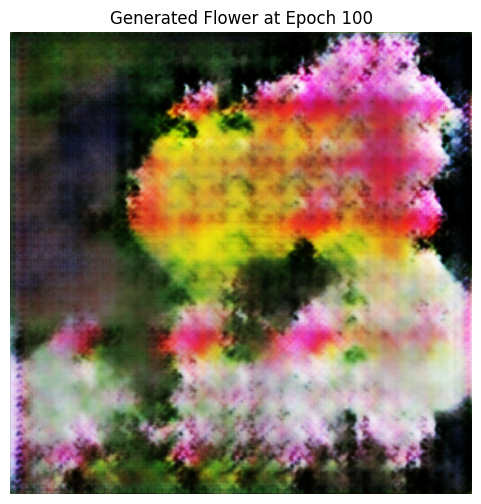

In [12]:
# 8. Training Loop
for epoch in range(1, num_epochs + 1):
    for real_imgs_batch in loader:
        real_imgs = real_imgs_batch[0].to(device)
        b_size = real_imgs.size(0)

        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        # Train Discriminator
        D.zero_grad()
        output_real = D(real_imgs)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = G(noise)
        output_fake = D(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        G.zero_grad()
        output = D(fake_imgs)
        g_loss = criterion(output, real_labels)
        g_loss.backward()
        optimizerG.step()

    print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Visualization
    if epoch % 10 == 0 or epoch == num_epochs:
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        img = fake[0].permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
        plt.figure(figsize=(6, 6))
        plt.imshow(img.numpy())
        plt.title(f"Generated Flower at Epoch {epoch}")
        plt.axis("off")
        plt.show()

In [13]:
from torchvision.utils import save_image
save_image(fake, "generated_flower.png", normalize=True)